# Latency Arbitrage
## CDA, 2M, 2MLA, CC

TODO:
   17. examine spread (NBBO)
   18. examine volatility
   19. examine surplus (ZI only)

In [3]:
%matplotlib inline
import numpy as np
import bisect
import matplotlib.pyplot as plt
from collections import deque
import seaborn as sns

import warnings

warnings.simplefilter("error")

## Classes and functions

In [4]:
class Order:
    """ This is how the orders in this system are represented,
        mostly straightforward.
        *Market may change during routing*
        The default value is the market where the order originates from.
    """
    def __init__(self, price, valuation, time, market):
        self.p = price
        self.pv = valuation
        self.t = time
        self.m = market
        
    def __getitem__(self, i):
        if i is 0:
            return self.p
        elif i is 1:
            return self.pv
        elif i is 2:
            return self.t
        elif i is 3:
            return self.m
        else:
            raise IndexError("{} is not a valid index.\n Use 0 for price, 1 for valuation, 2 for time".format(i))

In [5]:
class KeyWrapper:
    """ This is a helper function to maintain fast insertion 
        into a sorted queue with designated keys.
    """
    def __init__(self, iterable, key):
        self.it = iterable
        self.key = key

    def __getitem__(self, i):
        return self.key(self.it[i])

    def __len__(self):
        return len(self.it)

In [6]:
def surplus(ask,bid,t,rho):
    """ This is how the discounted surplus per order is calculated.
        rho is the discount factor, and it counts for the
        traders' preference for orders to be executed sooner.
    """
    # ask/bid order: [price,valuation,time placed, market]
    p = ask.p # assmue ask is the incumbent order
    if t is ask.t: # unless bid is...
        p = bid.p
    return  np.exp(-rho*(t-bid.t))*(bid.pv-p) + \
            np.exp(-rho*(t-ask.t))*(p-ask.pv)

In [7]:
def clearing(M,m,t,sip,delta,surpluses,execution_times,n_executions,rho):
    """ This is the clearing rule.
        TODO: improve efficiency
            It is called EVERY time step which is a bit excessive.
            Might want to schedule it somehow.
        The clearing rule tries to match orders in a given market.
        It records the surplus and execution time for the orders.
        Lastly, it sends the market status to SIP.
    """
    # Clear if ask < bid
    if (M[m].ask_q[0].p <= M[m].bid_q[-1].p):
        # clear the 2 orders
        ask = M[m].ask_q.popleft()
        bid = M[m].bid_q.pop()
        # Metrics related to order clearning
        #     calculate the surplus
        surpluses.append(surplus(ask,bid,t,rho))
        #     calculate the execution time (for one of them it's just 0)
        execution_times.append(abs(ask.t-bid.t))
        #     increment # order executed by two
        n_executions[0] += 2
        #     free up the two traders (we don't do this :\)
        #n_orders -=2
        
        #######################Tracing
        
        #print (t,abs(ask.t-bid.t))
        #print (ask.p,ask.t,":",bid.p,bid.t)
        
        #print("clearing",ask.p,ask.t,":",bid.p,bid.t,"\n")
        
        #A_entry=[t,ask.p]
        #idx = bisect.bisect(KeyWrapper(Ask_t, key=lambda c: c[0]), A_entry[0])
        #Ask_t.insert(idx, A_entry)
        #B_entry=[t,bid.p]
        #idx = bisect.bisect(KeyWrapper(Bid_t, key=lambda c: c[0]), B_entry[0])
        #Bid_t.insert(idx, B_entry)

    # send new market status to SIP
    sip.send(t,delta,m,M[m].ask_q[0],M[m].bid_q[-1])
        
    

In [8]:
class Market:
    """ This is how the orders in this system are represented.
        It consists of a double-entry queue for both the
        ask queue and bid queue.
    """
    def __init__(self):
        self.ask_q = deque()
        self.ask_q.append(Order(float('inf'),float('inf'),0,-1))
        self.bid_q = deque()
        self.bid_q.append(Order(-float('inf'),-float('inf'),0,-1))
        

In [9]:
class SIP:
    """ Security Information Processor
        This objects contains the neccsary functions for SIP,
            a queue for the market status reports,
            the SIP's recording of market status,
            as well as the NBBO (National Best Bid and Offer).
        send() takes in market status reports.
        updateNBBO() updates the NBBO.
        ProcesQuote() processes the market status reports
            in the SIP's queue and updates the SIP's recording.
    """
    def __init__(self,n_markets):
        self.q = deque([]) #[scheduled_time,market,ask_order,bid_order]
        self.market_asks = [Order(float('inf'),float('inf'),0,-1)]*n_markets
        self.market_bids = [Order(-float('inf'),-float('inf'),0,-1)]*n_markets
        self.NBBO_ask = Order(float('inf'),float('inf'),0,-1)
        self.NBBO_bid = Order(-float('inf'),-float('inf'),0,-1)
    
    def send(self,entry_time,delta,market,ask_order,bid_order):
        sip_entry = [entry_time+delta,market,ask_order,bid_order]
        idx = bisect.bisect(KeyWrapper(self.q, key=lambda c: c[0]), sip_entry[0])
        self.q.insert(idx, sip_entry)
        
    def updateNBBO(self):
        self.NBBO_ask = min(self.market_asks, key=lambda c: c.p)
        self.NBBO_bid = max(self.market_bids, key=lambda c: c.p)
        
    def ProcessQuote(self,t):
        while (self.q and self.q[0][0]<=t):
            entry = self.q.popleft()
            self.market_asks[entry[1]] = entry[2]
            self.market_bids[entry[1]] = entry[3]
            self.updateNBBO()

In [10]:
def routing(o,M,sip,o_type):
    """ The traders will post orders in their (single) primary market
        unless the NBBO tells them that there is an order in another market that:
            1. Can be executed immediately, and
            2. Is better than that in their primary market.
        This function returns the market # for the routed market.
    """
    # o_type: 1 for ask, 2 for bid
    if o_type is 2:
        # P > AskN and AskN < Ask1
        if o.p >= sip.NBBO_ask.p and sip.NBBO_ask.p < M[o.m].ask_q[0].p:
            o.m = sip.NBBO_ask.m
        idx = bisect.bisect(KeyWrapper(M[o.m].bid_q, key=lambda c: c.p), o.p)
        M[o.m].bid_q.insert(idx, o)
    elif o_type is 1:
        if o.p <= sip.NBBO_bid.p and sip.NBBO_bid.p > M[o.m].bid_q[-1].p:
            o.m = sip.NBBO_bid.m
            #print("routed")
        idx = bisect.bisect(KeyWrapper(M[o.m].ask_q, key=lambda c: c.p), o.p)
        M[o.m].ask_q.insert(idx, o)
    else:
        raise IndexError("{} is not a valid order type.\n Use 1 for ask, 2 for bid".format(o_type))
    return o.m

In [11]:
def LA(M,t,a):
    asks = [market.ask_q[0] for market in M]
    bids = [market.bid_q[-1] for market in M]
    ask = min(asks, key=lambda c: c.p)
    bid = max(bids, key=lambda c: c.p)
    
    markets_to_clear = []

    if (bid.p > (1+a)*ask.p):
        p_mid = (bid.p+ask.p)/2
        p_buy = np.floor(p_mid)
        p_sell = np.ceil(p_mid)
        #print("arbitrage at",p_buy,"&",p_sell)
        
        o_buy = Order(p_buy,p_mid,t,ask.m)
        idx = bisect.bisect(KeyWrapper(M[o_buy.m].bid_q, key=lambda c: c.p), o_buy.p)
        M[o_buy.m].bid_q.insert(idx, o_buy)
        
        o_sell = Order(p_sell,p_mid,t,bid.m)
        idx = bisect.bisect(KeyWrapper(M[o_sell.m].ask_q, key=lambda c: c.p), o_sell.p)
        M[o_sell.m].ask_q.insert(idx, o_sell)
        
        markets_to_clear = [o_buy.m, o_sell.m]
        
    return markets_to_clear

## Simulation

In [65]:
def simulate(n_markets, 
             nbt, 
             hasLA = False,
             clearing_interval = 0, # experimental
             n_epoch = 200,
             delta_range = [i*100 for i in range(0,11)], # variable, ranging from 0 10 1000 
             nt = 15000,
             a = 0.001,
             r_bar = 100000,
             k = 0.05,
             s2pv = 100000000,
             s2s = 150000000,
             R = 2000,
             rho = 0.0006,
             l = 0.075 # an ZI agent arrives per 13 to 14 time steps
            ):
    # calculate standard deviation
    spv = s2pv**0.5, #10000,
    ss = s2s**0.5, #12247.4,
    
    surplus_arr = []
    exe_time_arr = []
    spread_arr = []
    vola_arr = []
    
    print("Simulation Began.")

    # evaluate for each delta
    for delta in delta_range:

        # reset random numbers
        np.random.seed(12345)

        # reset per delta metrics
        surplus_a = []
        exe_time_a = []
        spread_a = []
        vola_a = []

        print("Simulating with delta = ",delta,"...")

        # evaluate over a number of runs
        for j in range(n_epoch):

            # set ZI_arrival intervals
            # note that since each agent only places one order, 
            # an offset (cumsum) of this becomes the arrival times.
            ZI_agent_arrival = np.random.exponential(1/l,nt)
            # randomly distribute the agents to each market
            # note that this should be the same given the same seed.
            ZI_agent_market = []
            for i in range(n_markets):
                ZI_agent_market.extend([i]*nbt[i])
            ZI_agent_market = np.random.permutation(ZI_agent_market)
            # movement of the asset value
            u = np.random.normal(0,ss,nt)

            # initialize simulation variables
            r = [r_bar]
            t_prev_arrival = 0
            n_arrival = 0
            n_orders = [0]*n_markets
            M = [Market() for _ in range(n_markets)]
            sip = SIP(n_markets)

            # trace
            #Ask_t = []
            #Bid_t = []

            # initialize metrics tracking variables
            surpluses = []
            n_executions = [0]
            execution_times = []
            spreads = [0]
            mqps = []

            for t in range(1,nt):

                # update price
                r.append(max(0,k*r_bar+(1-k)*r[t-1]+u[t]))

                # see if agent arrives
                if (sum(n_orders) < sum(nbt) and t_prev_arrival+ZI_agent_arrival[n_arrival]<t):
                    # see which market the agent is from
                    ziam = ZI_agent_market[n_arrival]

                    # update arrival event scheduling
                    t_prev_arrival += ZI_agent_arrival[n_arrival]
                    n_arrival += 1

                    # generate valuation
                    d = np.random.normal(r[t],spv)
                    PV = max(0,d)

                    # place order
                    order_type = 0 # undecided
                    if (np.random.uniform() > 0.5): # buy
                        P = max(0,np.random.uniform(PV-R,PV))
                        order_type = 1
                    else: # sell
                        P = max(0,np.random.uniform(PV,PV+R))
                        order_type = 2

                    ####
                    #print("order",ziam,t,P,order_type)
                    #print(sip.NBBO_ask.p,sip.NBBO_bid.p)
                    ####

                    # creating order
                    o = Order(P,PV,t,ziam)
                    # Route to the right market, record it in a variable
                    rm = routing(o,M,sip,order_type)
                    n_orders[ziam] += 1 # this has nothing to do with 
                    # where the order is routed, only where the agent is from.

                    # -Begin (Continuous Market Clearing)-
                    if clearing_interval <= 0:
                        # clear market bid-ask price
                        clearing(M,rm,t,sip,delta,surpluses,execution_times,n_executions,rho)

                        # -Begin (Latency Arbitrage)-
                        #     LA will trigger iff 
                        #     an order is placed and not immediately cleared
                        if hasLA:
                            mLA = LA(M,t,a)
                            for m in mLA:
                                clearing(M,m,t,sip,delta,surpluses,execution_times,n_executions,rho)
                        # -End (Latency Arbitrage)-
                    # -End (Continuous Market Clearing)-
                # -End of agent related processes-

                # SIP has it's own processing que 
                # and will need to be checked at every timestep
                sip.ProcessQuote(t)
                
                # -Begin (Discrete Market Clearing)-
                if clearing_interval > 0 and t%int(delta/10+1) is 0:
                #if clearing_interval > 0 and t%clearing_interval is 0:
                    # clear market bid-ask price
                    for m in range(n_markets):
                        clearing(M,m,t,sip,delta,surpluses,execution_times,n_executions,rho)

                    # -Begin (Latency Arbitrage)-
                    #     LA will trigger iff 
                    #     an order is placed and not immediately cleared
                    if hasLA:
                        mLA = LA(M,t,a)
                        for m in mLA:
                            clearing(M,m,t,sip,delta,surpluses,execution_times,n_executions,rho)
                    # -End (Latency Arbitrage)-
                # -End (Discrete Market Clearing)-
                
                # -Begin (some metrics)-
                if t < 3000:
                    # record spread
#                     for i in range(n_markets):
#                         spread = abs(M[i].ask_q[0].p-M[i].bid_q[-1].p)
#                         if (spread < float('inf')):
#                             spreads.append(spread)
                    spread = abs(sip.NBBO_ask.p-sip.NBBO_bid.p)
                    if (spread < float('inf')):
                        spreads.append(spread)

                    # record midquote price
                    if t%1 is 0:
                        mqp = abs(0.5*(sip.NBBO_ask.p+sip.NBBO_bid.p))
                        if (mqp < float('inf')):
                            mqps.append(mqp)
                # -End (some metrics)-
            # -End of time(t)-
                
            surplus_a.append(sum(surpluses))
            exe_time_a.append(sum(execution_times)/n_executions[0])
            #print (delta, j)
            #print(len(execution_times),sum(execution_times),n_executions[0])
            spread_a.append(np.median(spreads))
            vola_a.append(np.log(np.std(mqps)))
        # -End of epoch(j)-

        surplus_arr.append(np.mean(surplus_a))
        exe_time_arr.append(np.mean(exe_time_a))
        spread_arr.append(np.median(spread_a))
        vola_arr.append(vola_a[0])
    # -End of delta-
        
    print("Simulation Finished.")
    
    return surplus_arr, exe_time_arr, spread_arr, vola_arr

## Parameters

In [11]:
r_2M = simulate(n_markets = 2, nbt = [125,125], hasLA = False, n_epoch = 10)

Simulation Began.
Simulating with delta =  0 ...
Simulating with delta =  100 ...
Simulating with delta =  200 ...
Simulating with delta =  300 ...
Simulating with delta =  400 ...
Simulating with delta =  500 ...
Simulating with delta =  600 ...
Simulating with delta =  700 ...
Simulating with delta =  800 ...
Simulating with delta =  900 ...
Simulating with delta =  1000 ...
Simulation Finished.


In [16]:
r_2MLA = simulate(n_markets = 2, nbt = [125,125], hasLA = True, n_epoch = 10)

Simulation Began.
Simulating with delta =  0 ...
Simulating with delta =  100 ...
Simulating with delta =  200 ...
Simulating with delta =  300 ...
Simulating with delta =  400 ...
Simulating with delta =  500 ...
Simulating with delta =  600 ...
Simulating with delta =  700 ...
Simulating with delta =  800 ...
Simulating with delta =  900 ...
Simulating with delta =  1000 ...
Simulation Finished.


In [13]:
r_CDA = simulate(n_markets = 1, nbt = [250], hasLA = False, n_epoch = 10)

Simulation Began.
Simulating with delta =  0 ...
Simulating with delta =  100 ...
Simulating with delta =  200 ...
Simulating with delta =  300 ...
Simulating with delta =  400 ...
Simulating with delta =  500 ...
Simulating with delta =  600 ...
Simulating with delta =  700 ...
Simulating with delta =  800 ...
Simulating with delta =  900 ...
Simulating with delta =  1000 ...
Simulation Finished.


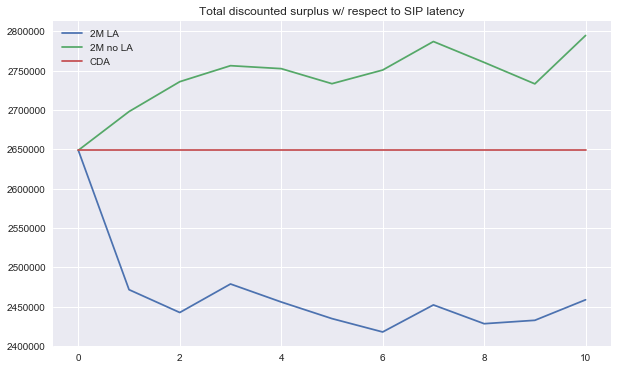

In [33]:
plt.figure(figsize=(10,6))
plt.plot(r_2MLA[0], label="2M LA")
plt.plot(r_2M[0], label="2M no LA")
plt.plot(r_CDA[0], label="CDA")
plt.legend()
plt.title("Total discounted surplus w/ respect to SIP latency")

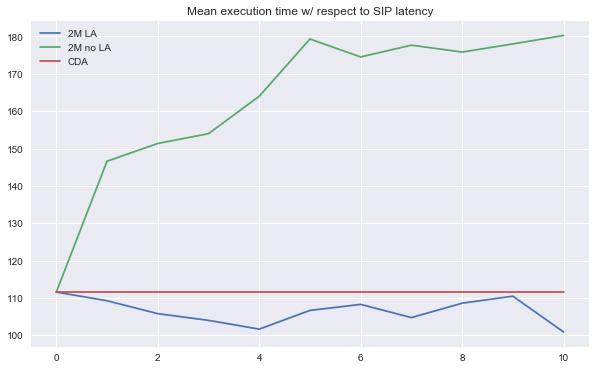

In [34]:
plt.figure(figsize=(10,6))
plt.plot(r_2MLA[1], label="2M LA")
plt.plot(r_2M[1], label="2M no LA")
plt.plot(r_CDA[1], label="CDA")
plt.legend()
plt.title("Mean execution time w/ respect to SIP latency")

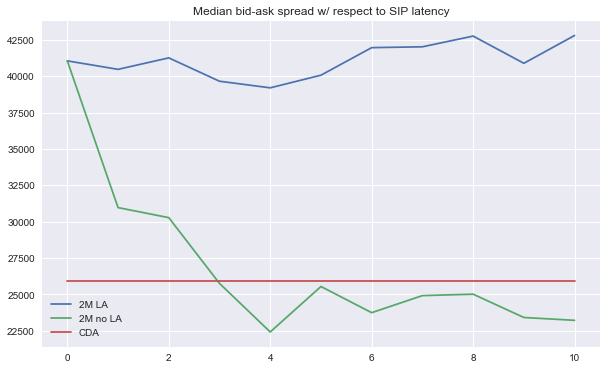

In [35]:
plt.figure(figsize=(10,6))
plt.plot(r_2MLA[2], label="2M LA")
plt.plot(r_2M[2], label="2M no LA")
plt.plot(r_CDA[2], label="CDA")
plt.legend()
plt.title("Median bid-ask spread w/ respect to SIP latency")

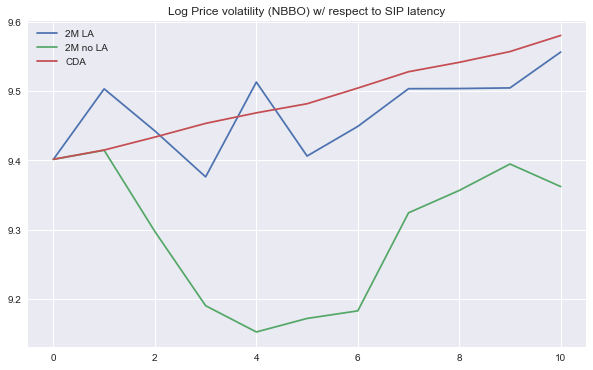

In [36]:
plt.figure(figsize=(10,6))
plt.plot(r_2MLA[3], label="2M LA")
plt.plot(r_2M[3], label="2M no LA")
plt.plot(r_CDA[3], label="CDA")
plt.legend()
plt.title("Log Price volatility (NBBO) w/ respect to SIP latency")

In [18]:
# Ask_t_t = [x[0] for x in Ask_t]
# Ask_t_p = [x[1] for x in Ask_t]
# Bid_t_t = [x[0] for x in Bid_t]
# Bid_t_p = [x[1] for x in Bid_t]

In [19]:
# plt.figure(figsize=(10,6))
# plt.plot(r,label="r")
# plt.plot(Ask_t_t,Ask_t_p,label="a")
# plt.plot(Bid_t_t,Bid_t_p,label="b")
# plt.legend()
# plt.xlim(0,3000)

In [20]:
#surplus_arr

In [21]:
#exe_time_arr

In [14]:
clitv = 50

In [110]:
r_D2M = simulate(n_markets = 2, nbt = [125,125], hasLA = False, clearing_interval = clitv, n_epoch = 10)

Simulation Began.
Simulating with delta =  0 ...
Simulating with delta =  100 ...
Simulating with delta =  200 ...
Simulating with delta =  300 ...
Simulating with delta =  400 ...
Simulating with delta =  500 ...
Simulating with delta =  600 ...
Simulating with delta =  700 ...
Simulating with delta =  800 ...
Simulating with delta =  900 ...
Simulating with delta =  1000 ...
Simulation Finished.


In [66]:
r_D2MLA = simulate(n_markets = 2, nbt = [125,125], hasLA = True, clearing_interval = clitv, n_epoch = 10)

Simulation Began.
Simulating with delta =  0 ...
Simulating with delta =  100 ...
Simulating with delta =  200 ...
Simulating with delta =  300 ...
Simulating with delta =  400 ...
Simulating with delta =  500 ...
Simulating with delta =  600 ...
Simulating with delta =  700 ...
Simulating with delta =  800 ...
Simulating with delta =  900 ...
Simulating with delta =  1000 ...
Simulation Finished.


In [112]:
r_CC = simulate(n_markets = 1, nbt = [250], hasLA = False, clearing_interval = clitv, n_epoch = 10)

Simulation Began.
Simulating with delta =  0 ...
Simulating with delta =  100 ...
Simulating with delta =  200 ...
Simulating with delta =  300 ...
Simulating with delta =  400 ...
Simulating with delta =  500 ...
Simulating with delta =  600 ...
Simulating with delta =  700 ...
Simulating with delta =  800 ...
Simulating with delta =  900 ...
Simulating with delta =  1000 ...
Simulation Finished.


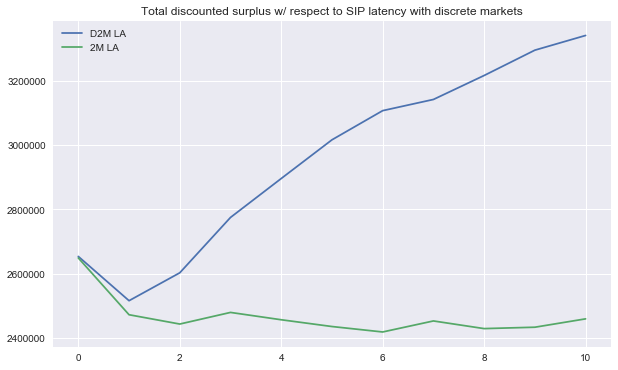

In [67]:
plt.figure(figsize=(10,6))
plt.plot(r_D2MLA[0], label="D2M LA")
plt.plot(r_2MLA[0], label="2M LA")
#plt.plot(r_D2M[0], label="D2M no LA")
#plt.plot(r_CC[0], label="Central Call")
plt.legend()
plt.title("Total discounted surplus w/ respect to SIP latency with discrete markets")

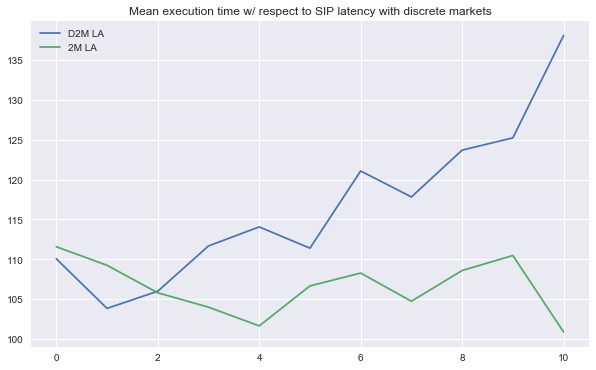

In [68]:
plt.figure(figsize=(10,6))
plt.plot(r_D2MLA[1], label="D2M LA")
plt.plot(r_2MLA[1], label="2M LA")
#plt.plot(r_D2M[1], label="D2M no LA")
#plt.plot(r_CC[1], label="Central Call")
plt.legend()
plt.title("Mean execution time w/ respect to SIP latency with discrete markets")

In [28]:
r_2MLAA = simulate(n_markets = 2, nbt = [125,125], hasLA = True, n_epoch = 10)

Simulation Began.
Simulating with delta =  0 ...
Simulating with delta =  100 ...
Simulating with delta =  200 ...
Simulating with delta =  300 ...
Simulating with delta =  400 ...
Simulating with delta =  500 ...
Simulating with delta =  600 ...
Simulating with delta =  700 ...
Simulating with delta =  800 ...
Simulating with delta =  900 ...
Simulating with delta =  1000 ...
Simulation Finished.


In [34]:
r_D2MLA = simulate(n_markets = 2, nbt = [125,125], hasLA = True, clearing_interval = clitv, n_epoch = 10)

Simulation Began.
Simulating with delta =  0 ...
Simulating with delta =  100 ...
Simulating with delta =  200 ...
Simulating with delta =  300 ...
Simulating with delta =  400 ...
Simulating with delta =  500 ...
Simulating with delta =  600 ...
Simulating with delta =  700 ...
Simulating with delta =  800 ...
Simulating with delta =  900 ...
Simulating with delta =  1000 ...
Simulation Finished.


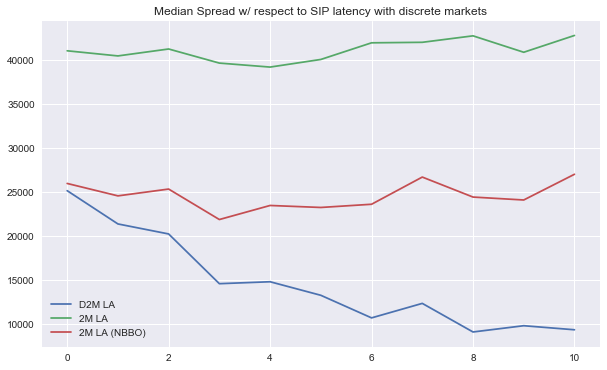

In [69]:
plt.figure(figsize=(10,6))
plt.plot(r_D2MLA[2], label="D2M LA")
plt.plot(r_2MLA[2], label="2M LA")
plt.plot(r_2MLAA[2], label="2M LA (NBBO)")
#plt.plot(r_D2M[2], label="D2M no LA")
#plt.plot(r_CC[2], label="Central Call")
plt.legend()
plt.title("Median Spread w/ respect to SIP latency with discrete markets")

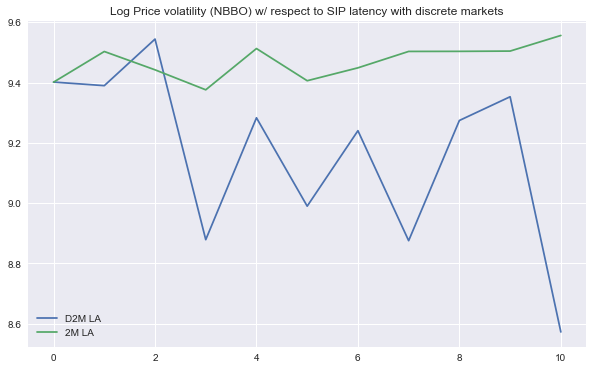

In [70]:
plt.figure(figsize=(10,6))
plt.plot(r_D2MLA[3], label="D2M LA")
plt.plot(r_2MLA[3], label="2M LA")
#plt.plot(r_D2M[3], label="D2M no LA")
#plt.plot(r_CC[3], label="Central Call")
plt.legend()
plt.title("Log Price volatility (NBBO) w/ respect to SIP latency with discrete markets")